In [12]:

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import  precision_score, recall_score,balanced_accuracy_score
import seaborn as sns
from tqdm import tqdm
from utils.Preprocessing_utils import output_selection_prepro
from utils.heatmap_plots import plot_heat_map, plot_metrics
from predict_model import test_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.FeedForwardNet.medium_complexity_model import Net as Net3
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau
from utils.EarlyStopping import EarlyStopping
from imblearn.combine import SMOTEENN, SMOTETomek
import pytorch_warmup as warmup
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F


In [13]:
df = pd.read_csv('data/raw/dukecathr.csv')# Read the data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")# Check whether a GPU is present, if yes then use it

In [14]:
#lists to store the results
train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]
balance_accuracy_list = []
precision_list = []
recall_list = []

### `train_epoch` Function

This function is responsible for training the model for one epoch. It iterates over the provided dataloader, computes the predictions using the model, calculates the loss, performs backpropagation, and updates the model parameters using the optimizer. The running loss and the number of correct predictions are accumulated over all the batches. The training loss and accuracy for the epoch are then calculated and returned.

- `model`: The model to be trained.
- `dataloader`: The PyTorch dataloader for training data.
- `criterion`: The loss function.
- `optimizer`: The optimizer (e.g., SGD, Adam).
- `lr_scheduler`: Learning rate scheduler.
- `warmup_scheduler`: Scheduler to warm up the learning rate over a certain amount of epochs.

In [15]:
def train_epoch(model, dataloader, criterion, optimizer, lr_scheduler, warmup_scheduler):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for data in tqdm(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        pred = model(inputs)
        predicted = torch.round(pred)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        with warmup_scheduler.dampening():
              lr_scheduler.step()
        running_loss += loss.item()
    train_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    return train_loss, accu

### `evaluate_epoch` Function

This function is responsible for evaluating the model after one epoch. It iterates over the provided dataloader, computes the predictions using the model, and calculates the loss. The running loss and the number of correct predictions are accumulated over all the batches. The evaluation loss, accuracy, balanced accuracy, precision, and recall for the epoch are then calculated and returned.

- `model`: The model to be evaluated.
- `dataloader`: The PyTorch dataloader for evaluation data.
- `criterion`: The loss function.

In [16]:
def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()# Count the number of correct predictions
        loss = criterion(outputs, labels)# Calculate the loss for current batch
        running_loss += loss.item()# Accumulate the loss for each batch

        # Store all labels and predictions for metric calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.detach().cpu().numpy())  # Detach the tensor before converting to numpy
            
    test_loss=running_loss/len(dataloader)
    test_accu=100.*correct/total

    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return test_loss, test_accu, balance_acc, precision, recall

### `train_model` Function

This function is responsible for training the model for a specified number of epochs and evaluating it after each epoch. It calls the `train_epoch` and `evaluate_epoch` functions inside a loop for a specified number of epochs. After each epoch, it saves the model if the balanced accuracy is higher than the current best.

- `model`: The model to be trained.
- `train_dataloader`: The PyTorch dataloader for training data.
- `test_dataloader`: The PyTorch dataloader for evaluation data.
- `criterion`: The loss function.
- `optimizer`: The optimizer (e.g., SGD, Adam).
- `num_epochs`: The number of epochs to train the model for.
- `target`: The target variable for the model.

In [17]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=25,target ='RCAST'):
    model_path=F'models/FeedForwardNet/saved_models/{target}/best_model.pth'# Path to save the best model
    model = model.to(device)
    all_learning_rates = []# Store all learning rates during training
    best_bal_acc = 0
    # Cosine annealing learning rate scheduler.T_max is the number of iterations in the epoch
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_dataloader) * num_epochs)
    
    warmup_scheduler = warmup.RAdamWarmup(optimizer) #https://arxiv.org/pdf/1910.04209.pdf
    
    #early_stopping = EarlyStopping(patience=30, verbose=True, model_path=model_path, delta=0.0001)

    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}')
        # Train the model for one epoch
        train_loss, accu = train_epoch(model, train_dataloader, criterion, optimizer, lr_scheduler,warmup_scheduler)
        train_accu.append(accu)
        train_losses.append(train_loss)
        # Evaluate the model on validation set
        test_loss, test_accu, balance_acc, precision, recall = evaluate_epoch(model, test_dataloader, criterion)
        eval_losses.append(test_loss)
        eval_accu.append(test_accu)
        balance_accuracy_list.append(balance_acc)
        precision_list.append(precision)
        recall_list.append(recall)
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {accu:.3f} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_accu:.3f} | Balance Accuracy: {balance_acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}')
        all_learning_rates.append(optimizer.param_groups[0]["lr"])
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')
   
        #remove the comment to use early stopping
        ''' early_stopping(test_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        '''
        # Save the model if the balanced accuracy is higher than the current best
        if balance_acc > best_bal_acc:
            print(f'Balanced accuracy increased ({best_bal_acc:.6f} --> {balance_acc:.6f}).  Saving model ...')
            os.makedirs(os.path.dirname(model_path), exist_ok=True)
            torch.save(model.state_dict(), model_path)  # Save the model
            best_bal_acc = balance_acc  # Update the best balanced accuracy
    plt.plot(all_learning_rates)
    plt.show()
        

### `FocalLoss` Class

This class defines a custom loss function called Focal Loss, which is designed to address class imbalance by down-weighting well-classified examples and focusing more on incorrectly classified examples. The Focal Loss is defined as `-alpha * (1-pt)^gamma * log(pt)`, where `pt` is the probability of being classified to the correct class.

- `alpha`: A weighting factor for the rare class in the case of class imbalance.
- `gamma`: A focusing parameter that reduces the relative loss for well-classified examples and puts more focus on hard, misclassified examples.
- `logits`: Whether to apply the sigmoid function to the inputs before computing the loss.
- `reduce`: Whether to average the loss over the batch samples.

In [18]:


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha #The alpha parameter is a weighting factor for the rare class in the case of class imbalance.
        self.gamma = gamma #The gamma parameter is a focusing parameter that reduces the relative loss for well-classified examples and puts more focus on hard, misclassified examples.
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)#pt is the probability of being classified to the correct class. 
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss #Focal loss is only computed on the hard examples. The loss is down-weighted if the model is confident about the prediction.

        if self.reduce:
            return torch.mean(F_loss)# The focal loss is averaged over the batch samples.
        else:
            return F_loss

### `evaluate_model` Function

This function is responsible for evaluating the model on a dataset. It iterates over the provided dataloader, computes the predictions using the model, and calculates the loss. The running loss and the number of correct predictions are accumulated over all the batches. The evaluation loss and accuracy are then calculated and printed.

- `model`: The model to be evaluated.
- `dataloader`: The PyTorch dataloader for the data to be evaluated.
- `criterion`: The loss function.

In [19]:
def evaluate_model(model, dataloader, criterion):
    model = model.to(device)  # Move the model to the GPU
    model.eval()  # Set model to evaluate mode
    running_loss=0
    correct=0
    total=0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Store all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    test_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Append the metrics to the lists
    balance_accuracy_list.append(balance_acc)
    precision_list.append(precision)
    recall_list.append(recall)

    print(f'Test Loss: {test_loss:.3f} | Accuracy: {accu:.3f}')

### `process_target` Function

This function is responsible for the entire machine learning process from preprocessing the data to evaluating the model. It takes a dataframe, a target variable, and a model as arguments.

- `df`: The dataframe containing the data.
- `target`: The target variable for the model.
- `model`: The model to be trained.

The function performs the following steps:

1. Preprocesses the data using the `output_selection_prepro` function.
2. Splits the data into training and test sets using the `train_test_split` function from sklearn.
3. Balances the training set using the `SMOTEENN` function which is a combination of over-sampling and under-sampling.
4. Scales the features using the `StandardScaler` function from sklearn.
5. Converts the features and labels to PyTorch tensors.
6. Converts the data into PyTorch tensors and loads them into a DataLoader.
7. Defines the model, loss function, and optimizer. The model is defined outside the function```

In [20]:
def process_target(df, target, model):
   # Step 1: Preprocess the data
   # The output_selection_prepro function is assumed to perform preprocessing tasks such as
   # encoding categorical variables, handling missing values, etc.
   X, y, num_cols, cat_cols = output_selection_prepro(df, target)

   # Step 2: Split the data into train and test sets
   # The train_test_split function from sklearn is used here to split the data.
   # 25% of the data is used for testing.
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
   
   # Print the counts of each class in the target variable for the training set
   unique, counts = np.unique(y_train, return_counts=True)
   print(dict(zip(unique, counts)))
   
   # Step 3: Balance the training set
   # The SMOTEENN function is a combination of over-sampling and under-sampling,
   # using SMOTE and Edited Nearest Neighbours to balance the data.
   smote_enn = SMOTEENN()
   X_train, y_train = smote_enn.fit_resample(X_train, y_train)
   
   # Print the counts of each class in the target variable for the balanced training set
   unique, counts = np.unique(y_train, return_counts=True)
   print(dict(zip(unique, counts)))
   
   # Step 4: Scale the features
   # The StandardScaler function standardizes features by removing the mean and scaling to unit variance.
   Scaler = StandardScaler()
   X_train = Scaler.fit_transform(X_train)
   X_test = Scaler.transform(X_test)
   
   # Step 5: Convert features and labels to tensors
   # The features and labels are converted to PyTorch tensors to be able to use them in the model.
   X_train_tensor = torch.tensor(X_train.astype(np.float32))
   X_test_tensor = torch.tensor(X_test.astype(np.float32))
   y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
   y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

   # Step 6: Convert the data into PyTorch tensors and load them into a DataLoader
   # The DataLoader will generate batches of data to be used in the model.
   train_data = TensorDataset(X_train_tensor, y_train_tensor)
   test_data = TensorDataset(X_test_tensor, y_test_tensor)
   
   # Save the test data for later use
   torch.save(test_data, f'data/processed/{target}/test_data.pth')

   # Define the batch size
   batch_size = 1024
   
   # Create the DataLoaders for the training and test sets
   train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
   test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

   # Step 7: Define the model, loss function, and optimizer
   # The model is defined outside the function and passed as an argument.
   # The Binary Cross Entropy loss is used as the loss function.
   # The AdamW optimizer is used. Modify beta to make the warmup scheduler more aggressive.
   model = model
   criterion = nn.BCELoss()
   optimizer = torch.optim.AdamW(model.parameters(),lr=0.00045, betas=(0.9, 0.9925))

   # Step 8: Train the model
   # The model is trained for specified epochs.
   train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100, target=target)

   # Step 9: Evaluate the model
   # The model is evaluated on the test set.
   evaluate_model(model, test_loader, criterion)

Processing target: LMST
Loading data from data/processed/LMST/imputed_data_LMST.csv...
No missing values found.
Final X columns: ['RDAYSFROMINDEX', 'RSEQCATHNUM', 'RSUBJID', 'YRCATH_G', 'AGE_G', 'GENDER', 'RACE_G', 'DPCABG', 'DPMI', 'DPPCI', 'HXANGINA', 'HXCEREB', 'HXCHF', 'HXCOPD', 'HXDIAB', 'HXHTN', 'HXHYL', 'HXMI', 'HXSMOKE', 'NUMPRMI', 'DIASBP_R', 'PULSE_R', 'SYSBP_R', 'CBRUITS', 'HEIGHT_R', 'S3', 'WEIGHT_R', 'CREATININE_R', 'HDL_R', 'LDL_R', 'TOTCHOL_R', 'CATHAPPR', 'DIAGCATH', 'INTVCATH', 'CORDOM', 'GRAFTST', 'LVEF_R', 'DAYS2LKA', 'DSCABG', 'DSMI', 'DSPCI', 'DSSTROKE', 'FUPROTCL']
{0: 50071, 1: 3790}
{0: 36405, 1: 48139}
Epoch : 1


100%|██████████| 83/83 [00:01<00:00, 61.89it/s]


Train Loss: 0.654 | Train Accuracy: 61.448 | Test Loss: 0.685 | Test Accuracy: 56.834 | Balance Accuracy: 0.653 | Precision: 0.111 | Recall: 0.751
Learning rate: 0.00023763635191564314
Balanced accuracy increased (0.000000 --> 0.652694).  Saving model ...
Epoch : 2


100%|██████████| 83/83 [00:01<00:00, 80.27it/s]


Train Loss: 0.540 | Train Accuracy: 73.726 | Test Loss: 0.767 | Test Accuracy: 55.492 | Balance Accuracy: 0.667 | Precision: 0.114 | Recall: 0.797
Learning rate: 0.0003172689893763752
Balanced accuracy increased (0.652694 --> 0.667078).  Saving model ...
Epoch : 3


100%|██████████| 83/83 [00:01<00:00, 70.11it/s]


Train Loss: 0.492 | Train Accuracy: 76.747 | Test Loss: 0.748 | Test Accuracy: 59.597 | Balance Accuracy: 0.679 | Precision: 0.121 | Recall: 0.776
Learning rate: 0.0003650226361187831
Balanced accuracy increased (0.667078 --> 0.679077).  Saving model ...
Epoch : 4


100%|██████████| 83/83 [00:01<00:00, 79.59it/s]


Train Loss: 0.460 | Train Accuracy: 78.446 | Test Loss: 0.734 | Test Accuracy: 61.412 | Balance Accuracy: 0.690 | Precision: 0.127 | Recall: 0.778
Learning rate: 0.00039512675401656483
Balanced accuracy increased (0.679077 --> 0.689948).  Saving model ...
Epoch : 5


100%|██████████| 83/83 [00:01<00:00, 73.22it/s]


Train Loss: 0.436 | Train Accuracy: 79.837 | Test Loss: 0.696 | Test Accuracy: 64.632 | Balance Accuracy: 0.696 | Precision: 0.134 | Recall: 0.755
Learning rate: 0.00041401771656992447
Balanced accuracy increased (0.689948 --> 0.696444).  Saving model ...
Epoch : 6


100%|██████████| 83/83 [00:01<00:00, 70.10it/s]


Train Loss: 0.415 | Train Accuracy: 81.008 | Test Loss: 0.629 | Test Accuracy: 67.907 | Balance Accuracy: 0.694 | Precision: 0.141 | Recall: 0.712
Learning rate: 0.0004255074852427121
Epoch : 7


100%|██████████| 83/83 [00:01<00:00, 68.46it/s]


Train Loss: 0.401 | Train Accuracy: 81.843 | Test Loss: 0.662 | Test Accuracy: 66.553 | Balance Accuracy: 0.700 | Precision: 0.139 | Recall: 0.740
Learning rate: 0.0004320826195897291
Balanced accuracy increased (0.696444 --> 0.700065).  Saving model ...
Epoch : 8


100%|██████████| 83/83 [00:01<00:00, 69.97it/s]


Train Loss: 0.392 | Train Accuracy: 82.434 | Test Loss: 0.674 | Test Accuracy: 66.849 | Balance Accuracy: 0.702 | Precision: 0.141 | Recall: 0.741
Learning rate: 0.0004354064039091123
Balanced accuracy increased (0.700065 --> 0.702023).  Saving model ...
Epoch : 9


100%|██████████| 83/83 [00:01<00:00, 71.32it/s]


Train Loss: 0.382 | Train Accuracy: 82.784 | Test Loss: 0.648 | Test Accuracy: 67.122 | Balance Accuracy: 0.703 | Precision: 0.142 | Recall: 0.740
Learning rate: 0.0004365860926689495
Balanced accuracy increased (0.702023 --> 0.703117).  Saving model ...
Epoch : 10


100%|██████████| 83/83 [00:01<00:00, 62.57it/s]


Train Loss: 0.369 | Train Accuracy: 83.606 | Test Loss: 0.596 | Test Accuracy: 69.255 | Balance Accuracy: 0.705 | Precision: 0.147 | Recall: 0.718
Learning rate: 0.0004363470076131304
Balanced accuracy increased (0.703117 --> 0.704523).  Saving model ...
Epoch : 11


100%|██████████| 83/83 [00:01<00:00, 65.30it/s]


Train Loss: 0.363 | Train Accuracy: 83.852 | Test Loss: 0.653 | Test Accuracy: 67.389 | Balance Accuracy: 0.711 | Precision: 0.145 | Recall: 0.755
Learning rate: 0.00043515532882097815
Balanced accuracy increased (0.704523 --> 0.711255).  Saving model ...
Epoch : 12


100%|██████████| 83/83 [00:01<00:00, 73.11it/s]


Train Loss: 0.355 | Train Accuracy: 84.264 | Test Loss: 0.593 | Test Accuracy: 69.840 | Balance Accuracy: 0.709 | Precision: 0.150 | Recall: 0.722
Learning rate: 0.0004333053070178679
Epoch : 13


100%|██████████| 83/83 [00:01<00:00, 73.89it/s]


Train Loss: 0.350 | Train Accuracy: 84.570 | Test Loss: 0.532 | Test Accuracy: 72.290 | Balance Accuracy: 0.703 | Precision: 0.156 | Recall: 0.679
Learning rate: 0.00043097985749599647
Epoch : 14


100%|██████████| 83/83 [00:01<00:00, 72.74it/s]


Train Loss: 0.344 | Train Accuracy: 84.800 | Test Loss: 0.561 | Test Accuracy: 70.798 | Balance Accuracy: 0.707 | Precision: 0.153 | Recall: 0.706
Learning rate: 0.0004282914273915559
Epoch : 15


100%|██████████| 83/83 [00:01<00:00, 70.45it/s]


Train Loss: 0.338 | Train Accuracy: 85.035 | Test Loss: 0.553 | Test Accuracy: 71.756 | Balance Accuracy: 0.712 | Precision: 0.157 | Recall: 0.706
Learning rate: 0.0004253087671262516
Balanced accuracy increased (0.711255 --> 0.712000).  Saving model ...
Epoch : 16


100%|██████████| 83/83 [00:01<00:00, 73.67it/s]


Train Loss: 0.333 | Train Accuracy: 85.246 | Test Loss: 0.619 | Test Accuracy: 69.322 | Balance Accuracy: 0.721 | Precision: 0.153 | Recall: 0.753
Learning rate: 0.00042207402006155147
Balanced accuracy increased (0.712000 --> 0.720892).  Saving model ...
Epoch : 17


100%|██████████| 83/83 [00:01<00:00, 67.63it/s]


Train Loss: 0.328 | Train Accuracy: 85.533 | Test Loss: 0.592 | Test Accuracy: 70.190 | Balance Accuracy: 0.720 | Precision: 0.155 | Recall: 0.742
Learning rate: 0.00041861339319085804
Epoch : 18


100%|██████████| 83/83 [00:01<00:00, 70.66it/s]


Train Loss: 0.322 | Train Accuracy: 85.747 | Test Loss: 0.546 | Test Accuracy: 71.900 | Balance Accuracy: 0.718 | Precision: 0.159 | Recall: 0.716
Learning rate: 0.00041494369683075133
Epoch : 19


100%|██████████| 83/83 [00:01<00:00, 64.07it/s]


Train Loss: 0.319 | Train Accuracy: 86.016 | Test Loss: 0.517 | Test Accuracy: 73.092 | Balance Accuracy: 0.711 | Precision: 0.162 | Recall: 0.689
Learning rate: 0.000411076290140559
Epoch : 20


100%|██████████| 83/83 [00:01<00:00, 62.47it/s]


Train Loss: 0.314 | Train Accuracy: 86.194 | Test Loss: 0.520 | Test Accuracy: 73.198 | Balance Accuracy: 0.714 | Precision: 0.163 | Recall: 0.693
Learning rate: 0.0004070194299976968
Epoch : 21


100%|██████████| 83/83 [00:01<00:00, 70.53it/s]


Train Loss: 0.311 | Train Accuracy: 86.407 | Test Loss: 0.544 | Test Accuracy: 72.301 | Balance Accuracy: 0.719 | Precision: 0.161 | Recall: 0.715
Learning rate: 0.00040277965330027464
Epoch : 22


100%|██████████| 83/83 [00:01<00:00, 69.02it/s]


Train Loss: 0.308 | Train Accuracy: 86.554 | Test Loss: 0.563 | Test Accuracy: 71.215 | Balance Accuracy: 0.722 | Precision: 0.159 | Recall: 0.734
Learning rate: 0.0003983625820805697
Balanced accuracy increased (0.720892 --> 0.722129).  Saving model ...
Epoch : 23


100%|██████████| 83/83 [00:01<00:00, 62.76it/s]


Train Loss: 0.301 | Train Accuracy: 86.775 | Test Loss: 0.529 | Test Accuracy: 72.652 | Balance Accuracy: 0.725 | Precision: 0.165 | Recall: 0.723
Learning rate: 0.0003937733878572488
Balanced accuracy increased (0.722129 --> 0.725009).  Saving model ...
Epoch : 24


100%|██████████| 83/83 [00:01<00:00, 67.58it/s]


Train Loss: 0.301 | Train Accuracy: 86.833 | Test Loss: 0.525 | Test Accuracy: 73.109 | Balance Accuracy: 0.720 | Precision: 0.165 | Recall: 0.708
Learning rate: 0.0003890170567227455
Epoch : 25


100%|██████████| 83/83 [00:01<00:00, 76.24it/s]


Train Loss: 0.300 | Train Accuracy: 86.896 | Test Loss: 0.538 | Test Accuracy: 72.179 | Balance Accuracy: 0.727 | Precision: 0.163 | Recall: 0.732
Learning rate: 0.00038409853884071346
Balanced accuracy increased (0.725009 --> 0.726561).  Saving model ...
Epoch : 26


100%|██████████| 83/83 [00:01<00:00, 66.43it/s]


Train Loss: 0.292 | Train Accuracy: 87.259 | Test Loss: 0.552 | Test Accuracy: 71.700 | Balance Accuracy: 0.728 | Precision: 0.162 | Recall: 0.740
Learning rate: 0.0003790228313415343
Balanced accuracy increased (0.726561 --> 0.727711).  Saving model ...
Epoch : 27


100%|██████████| 83/83 [00:01<00:00, 70.94it/s]


Train Loss: 0.294 | Train Accuracy: 87.266 | Test Loss: 0.509 | Test Accuracy: 73.805 | Balance Accuracy: 0.719 | Precision: 0.167 | Recall: 0.696
Learning rate: 0.00037379502305344393
Epoch : 28


100%|██████████| 83/83 [00:01<00:00, 69.41it/s]


Train Loss: 0.290 | Train Accuracy: 87.444 | Test Loss: 0.526 | Test Accuracy: 73.209 | Balance Accuracy: 0.724 | Precision: 0.166 | Recall: 0.715
Learning rate: 0.0003684203174577136
Epoch : 29


100%|██████████| 83/83 [00:01<00:00, 71.46it/s]


Train Loss: 0.288 | Train Accuracy: 87.630 | Test Loss: 0.536 | Test Accuracy: 72.658 | Balance Accuracy: 0.727 | Precision: 0.165 | Recall: 0.727
Learning rate: 0.00036290404325350765
Epoch : 30


100%|██████████| 83/83 [00:01<00:00, 70.29it/s]


Train Loss: 0.285 | Train Accuracy: 87.690 | Test Loss: 0.526 | Test Accuracy: 73.310 | Balance Accuracy: 0.724 | Precision: 0.167 | Recall: 0.714
Learning rate: 0.0003572516578786159
Epoch : 31


100%|██████████| 83/83 [00:01<00:00, 74.17it/s]


Train Loss: 0.283 | Train Accuracy: 87.767 | Test Loss: 0.510 | Test Accuracy: 73.599 | Balance Accuracy: 0.724 | Precision: 0.168 | Recall: 0.710
Learning rate: 0.00035146874701734855
Epoch : 32


100%|██████████| 83/83 [00:01<00:00, 71.37it/s]


Train Loss: 0.278 | Train Accuracy: 87.932 | Test Loss: 0.488 | Test Accuracy: 74.908 | Balance Accuracy: 0.718 | Precision: 0.171 | Recall: 0.681
Learning rate: 0.0003455610218078231
Epoch : 33


100%|██████████| 83/83 [00:01<00:00, 72.48it/s]


Train Loss: 0.280 | Train Accuracy: 87.848 | Test Loss: 0.490 | Test Accuracy: 74.741 | Balance Accuracy: 0.718 | Precision: 0.170 | Recall: 0.684
Learning rate: 0.0003395343147130606
Epoch : 34


100%|██████████| 83/83 [00:01<00:00, 70.04it/s]


Train Loss: 0.277 | Train Accuracy: 88.044 | Test Loss: 0.490 | Test Accuracy: 74.880 | Balance Accuracy: 0.715 | Precision: 0.170 | Recall: 0.675
Learning rate: 0.0003333945745982791
Epoch : 35


100%|██████████| 83/83 [00:01<00:00, 74.07it/s]


Train Loss: 0.274 | Train Accuracy: 88.115 | Test Loss: 0.551 | Test Accuracy: 72.519 | Balance Accuracy: 0.728 | Precision: 0.165 | Recall: 0.730
Learning rate: 0.0003271478613195821
Epoch : 36


100%|██████████| 83/83 [00:01<00:00, 68.92it/s]


Train Loss: 0.274 | Train Accuracy: 88.171 | Test Loss: 0.512 | Test Accuracy: 73.649 | Balance Accuracy: 0.723 | Precision: 0.167 | Recall: 0.706
Learning rate: 0.0003208003399964389
Epoch : 37


100%|██████████| 83/83 [00:01<00:00, 73.33it/s]


Train Loss: 0.269 | Train Accuracy: 88.489 | Test Loss: 0.486 | Test Accuracy: 75.142 | Balance Accuracy: 0.720 | Precision: 0.173 | Recall: 0.684
Learning rate: 0.0003143582750662659
Epoch : 38


100%|██████████| 83/83 [00:01<00:00, 75.12it/s]


Train Loss: 0.269 | Train Accuracy: 88.327 | Test Loss: 0.504 | Test Accuracy: 74.084 | Balance Accuracy: 0.718 | Precision: 0.168 | Recall: 0.691
Learning rate: 0.00030782802417824253
Epoch : 39


100%|██████████| 83/83 [00:01<00:00, 69.60it/s]


Train Loss: 0.268 | Train Accuracy: 88.404 | Test Loss: 0.600 | Test Accuracy: 70.903 | Balance Accuracy: 0.731 | Precision: 0.160 | Recall: 0.756
Learning rate: 0.00030121603196067286
Balanced accuracy increased (0.727711 --> 0.730879).  Saving model ...
Epoch : 40


100%|██████████| 83/83 [00:01<00:00, 72.53it/s]


Train Loss: 0.263 | Train Accuracy: 88.729 | Test Loss: 0.495 | Test Accuracy: 74.702 | Balance Accuracy: 0.720 | Precision: 0.171 | Recall: 0.688
Learning rate: 0.0002945288236836196
Epoch : 41


100%|██████████| 83/83 [00:01<00:00, 76.40it/s]


Train Loss: 0.265 | Train Accuracy: 88.595 | Test Loss: 0.575 | Test Accuracy: 71.828 | Balance Accuracy: 0.733 | Precision: 0.164 | Recall: 0.750
Learning rate: 0.00028777299883162114
Balanced accuracy increased (0.730879 --> 0.732867).  Saving model ...
Epoch : 42


100%|██████████| 83/83 [00:01<00:00, 70.53it/s]


Train Loss: 0.261 | Train Accuracy: 88.735 | Test Loss: 0.487 | Test Accuracy: 75.125 | Balance Accuracy: 0.722 | Precision: 0.173 | Recall: 0.687
Learning rate: 0.000280955224597526
Epoch : 43


100%|██████████| 83/83 [00:01<00:00, 73.59it/s]


Train Loss: 0.261 | Train Accuracy: 88.782 | Test Loss: 0.486 | Test Accuracy: 74.986 | Balance Accuracy: 0.719 | Precision: 0.172 | Recall: 0.682
Learning rate: 0.0002740822293064334
Epoch : 44


100%|██████████| 83/83 [00:01<00:00, 70.94it/s]


Train Loss: 0.262 | Train Accuracy: 88.732 | Test Loss: 0.501 | Test Accuracy: 74.223 | Balance Accuracy: 0.721 | Precision: 0.169 | Recall: 0.697
Learning rate: 0.0002671607957776289
Epoch : 45


100%|██████████| 83/83 [00:01<00:00, 73.00it/s]


Train Loss: 0.255 | Train Accuracy: 89.001 | Test Loss: 0.481 | Test Accuracy: 75.437 | Balance Accuracy: 0.718 | Precision: 0.173 | Recall: 0.675
Learning rate: 0.0002601977546318335
Epoch : 46


100%|██████████| 83/83 [00:01<00:00, 74.71it/s]


Train Loss: 0.256 | Train Accuracy: 88.961 | Test Loss: 0.469 | Test Accuracy: 76.033 | Balance Accuracy: 0.718 | Precision: 0.176 | Recall: 0.669
Learning rate: 0.0002531999775507867
Epoch : 47


100%|██████████| 83/83 [00:01<00:00, 69.78it/s]


Train Loss: 0.254 | Train Accuracy: 89.102 | Test Loss: 0.488 | Test Accuracy: 75.209 | Balance Accuracy: 0.720 | Precision: 0.173 | Recall: 0.682
Learning rate: 0.0002461743704960367
Epoch : 48


100%|██████████| 83/83 [00:01<00:00, 72.32it/s]


Train Loss: 0.250 | Train Accuracy: 89.232 | Test Loss: 0.461 | Test Accuracy: 76.724 | Balance Accuracy: 0.715 | Precision: 0.178 | Recall: 0.654
Learning rate: 0.00023912786689376102
Epoch : 49


100%|██████████| 83/83 [00:01<00:00, 74.45it/s]


Train Loss: 0.253 | Train Accuracy: 89.265 | Test Loss: 0.560 | Test Accuracy: 72.524 | Balance Accuracy: 0.730 | Precision: 0.166 | Recall: 0.735
Learning rate: 0.00023206742079240117
Epoch : 50


100%|██████████| 83/83 [00:01<00:00, 75.05it/s]


Train Loss: 0.252 | Train Accuracy: 89.264 | Test Loss: 0.525 | Test Accuracy: 73.967 | Balance Accuracy: 0.727 | Precision: 0.170 | Recall: 0.713
Learning rate: 0.00022499999999990556
Epoch : 51


100%|██████████| 83/83 [00:01<00:00, 70.52it/s]


Train Loss: 0.248 | Train Accuracy: 89.236 | Test Loss: 0.488 | Test Accuracy: 75.376 | Balance Accuracy: 0.722 | Precision: 0.175 | Recall: 0.685
Learning rate: 0.00021793257920737095
Epoch : 52


100%|██████████| 83/83 [00:01<00:00, 73.05it/s]


Train Loss: 0.248 | Train Accuracy: 89.309 | Test Loss: 0.479 | Test Accuracy: 75.788 | Balance Accuracy: 0.721 | Precision: 0.176 | Recall: 0.679
Learning rate: 0.00021087213310587772
Epoch : 53


100%|██████████| 83/83 [00:01<00:00, 75.97it/s]


Train Loss: 0.250 | Train Accuracy: 89.286 | Test Loss: 0.525 | Test Accuracy: 73.978 | Balance Accuracy: 0.722 | Precision: 0.168 | Recall: 0.701
Learning rate: 0.00020382562950332003
Epoch : 54


100%|██████████| 83/83 [00:01<00:00, 66.51it/s]


Train Loss: 0.245 | Train Accuracy: 89.484 | Test Loss: 0.515 | Test Accuracy: 74.852 | Balance Accuracy: 0.729 | Precision: 0.175 | Recall: 0.706
Learning rate: 0.00019680002244802362
Epoch : 55


100%|██████████| 83/83 [00:01<00:00, 74.37it/s]


Train Loss: 0.244 | Train Accuracy: 89.527 | Test Loss: 0.466 | Test Accuracy: 76.852 | Balance Accuracy: 0.722 | Precision: 0.181 | Recall: 0.667
Learning rate: 0.00018980224536594356
Epoch : 56


100%|██████████| 83/83 [00:01<00:00, 69.09it/s]


Train Loss: 0.244 | Train Accuracy: 89.436 | Test Loss: 0.481 | Test Accuracy: 75.732 | Balance Accuracy: 0.721 | Precision: 0.176 | Recall: 0.678
Learning rate: 0.00018283920421820933
Epoch : 57


100%|██████████| 83/83 [00:01<00:00, 76.22it/s]


Train Loss: 0.244 | Train Accuracy: 89.536 | Test Loss: 0.572 | Test Accuracy: 71.154 | Balance Accuracy: 0.734 | Precision: 0.162 | Recall: 0.761
Learning rate: 0.00017591777068577628
Balanced accuracy increased (0.732867 --> 0.734460).  Saving model ...
Epoch : 58


100%|██████████| 83/83 [00:01<00:00, 71.07it/s]


Train Loss: 0.246 | Train Accuracy: 89.491 | Test Loss: 0.466 | Test Accuracy: 76.490 | Balance Accuracy: 0.721 | Precision: 0.179 | Recall: 0.670
Learning rate: 0.00016904477538790647
Epoch : 59


100%|██████████| 83/83 [00:01<00:00, 73.49it/s]


Train Loss: 0.241 | Train Accuracy: 89.646 | Test Loss: 0.484 | Test Accuracy: 75.571 | Balance Accuracy: 0.724 | Precision: 0.176 | Recall: 0.687
Learning rate: 0.0001622270011411724
Epoch : 60


100%|██████████| 83/83 [00:01<00:00, 71.21it/s]


Train Loss: 0.242 | Train Accuracy: 89.637 | Test Loss: 0.460 | Test Accuracy: 76.690 | Balance Accuracy: 0.717 | Precision: 0.179 | Recall: 0.659
Learning rate: 0.00015547117626563616
Epoch : 61


100%|██████████| 83/83 [00:01<00:00, 75.61it/s]


Train Loss: 0.241 | Train Accuracy: 89.702 | Test Loss: 0.469 | Test Accuracy: 76.696 | Balance Accuracy: 0.725 | Precision: 0.182 | Recall: 0.677
Learning rate: 0.00014878396794480868
Epoch : 62


100%|██████████| 83/83 [00:01<00:00, 69.39it/s]


Train Loss: 0.239 | Train Accuracy: 89.726 | Test Loss: 0.489 | Test Accuracy: 75.783 | Balance Accuracy: 0.727 | Precision: 0.178 | Recall: 0.690
Learning rate: 0.00014217197564594678
Epoch : 63


100%|██████████| 83/83 [00:01<00:00, 73.39it/s]


Train Loss: 0.240 | Train Accuracy: 89.760 | Test Loss: 0.477 | Test Accuracy: 75.972 | Balance Accuracy: 0.725 | Precision: 0.178 | Recall: 0.685
Learning rate: 0.00013564172460717367
Epoch : 64


100%|██████████| 83/83 [00:01<00:00, 67.91it/s]


Train Loss: 0.236 | Train Accuracy: 89.973 | Test Loss: 0.482 | Test Accuracy: 75.805 | Balance Accuracy: 0.727 | Precision: 0.178 | Recall: 0.691
Learning rate: 0.00012919965939785802
Epoch : 65


100%|██████████| 83/83 [00:01<00:00, 74.88it/s]


Train Loss: 0.238 | Train Accuracy: 89.902 | Test Loss: 0.476 | Test Accuracy: 76.267 | Balance Accuracy: 0.722 | Precision: 0.179 | Recall: 0.676
Learning rate: 0.00012285213755860132
Epoch : 66


100%|██████████| 83/83 [00:01<00:00, 69.62it/s]


Train Loss: 0.235 | Train Accuracy: 89.879 | Test Loss: 0.467 | Test Accuracy: 76.768 | Balance Accuracy: 0.720 | Precision: 0.180 | Recall: 0.665
Learning rate: 0.00011660542332711353
Epoch : 67


100%|██████████| 83/83 [00:01<00:00, 70.63it/s]


Train Loss: 0.236 | Train Accuracy: 89.859 | Test Loss: 0.475 | Test Accuracy: 76.657 | Balance Accuracy: 0.723 | Precision: 0.181 | Recall: 0.673
Learning rate: 0.00011046568145616594
Epoch : 68


100%|██████████| 83/83 [00:01<00:00, 69.47it/s]


Train Loss: 0.234 | Train Accuracy: 89.919 | Test Loss: 0.473 | Test Accuracy: 76.228 | Balance Accuracy: 0.726 | Precision: 0.180 | Recall: 0.684
Learning rate: 0.00010443897112972518
Epoch : 69


100%|██████████| 83/83 [00:01<00:00, 72.76it/s]


Train Loss: 0.233 | Train Accuracy: 90.077 | Test Loss: 0.478 | Test Accuracy: 76.295 | Balance Accuracy: 0.723 | Precision: 0.179 | Recall: 0.677
Learning rate: 9.853123998327003e-05
Epoch : 70


100%|██████████| 83/83 [00:01<00:00, 69.40it/s]


Train Loss: 0.233 | Train Accuracy: 90.013 | Test Loss: 0.469 | Test Accuracy: 76.902 | Balance Accuracy: 0.725 | Precision: 0.183 | Recall: 0.674
Learning rate: 9.274831823419293e-05
Epoch : 71


100%|██████████| 83/83 [00:01<00:00, 70.33it/s]


Train Loss: 0.233 | Train Accuracy: 90.017 | Test Loss: 0.468 | Test Accuracy: 76.590 | Balance Accuracy: 0.724 | Precision: 0.181 | Recall: 0.676
Learning rate: 8.709591292807976e-05
Epoch : 72


100%|██████████| 83/83 [00:01<00:00, 72.97it/s]


Train Loss: 0.235 | Train Accuracy: 89.980 | Test Loss: 0.463 | Test Accuracy: 76.880 | Balance Accuracy: 0.723 | Precision: 0.182 | Recall: 0.669
Learning rate: 8.157960230654428e-05
Epoch : 73


100%|██████████| 83/83 [00:01<00:00, 64.34it/s]


Train Loss: 0.233 | Train Accuracy: 90.004 | Test Loss: 0.482 | Test Accuracy: 76.022 | Balance Accuracy: 0.727 | Precision: 0.179 | Recall: 0.688
Learning rate: 7.620483030217786e-05
Epoch : 74


100%|██████████| 83/83 [00:01<00:00, 65.69it/s]


Train Loss: 0.233 | Train Accuracy: 90.047 | Test Loss: 0.469 | Test Accuracy: 76.534 | Balance Accuracy: 0.724 | Precision: 0.181 | Recall: 0.675
Learning rate: 7.097690116604467e-05
Epoch : 75


100%|██████████| 83/83 [00:01<00:00, 68.29it/s]


Train Loss: 0.234 | Train Accuracy: 89.880 | Test Loss: 0.493 | Test Accuracy: 75.615 | Balance Accuracy: 0.726 | Precision: 0.177 | Recall: 0.691
Learning rate: 6.590097423302637e-05
Epoch : 76


100%|██████████| 83/83 [00:01<00:00, 66.08it/s]


Train Loss: 0.234 | Train Accuracy: 90.015 | Test Loss: 0.475 | Test Accuracy: 76.429 | Balance Accuracy: 0.726 | Precision: 0.181 | Recall: 0.681
Learning rate: 6.0982058830182005e-05
Epoch : 77


100%|██████████| 83/83 [00:01<00:00, 65.78it/s]


Train Loss: 0.231 | Train Accuracy: 90.155 | Test Loss: 0.494 | Test Accuracy: 75.933 | Balance Accuracy: 0.727 | Precision: 0.179 | Recall: 0.689
Learning rate: 5.6225009333146185e-05
Epoch : 78


100%|██████████| 83/83 [00:01<00:00, 68.29it/s]


Train Loss: 0.231 | Train Accuracy: 90.119 | Test Loss: 0.468 | Test Accuracy: 76.813 | Balance Accuracy: 0.724 | Precision: 0.182 | Recall: 0.673
Learning rate: 5.1634520375447045e-05
Epoch : 79


100%|██████████| 83/83 [00:01<00:00, 63.86it/s]


Train Loss: 0.232 | Train Accuracy: 90.016 | Test Loss: 0.498 | Test Accuracy: 75.454 | Balance Accuracy: 0.728 | Precision: 0.177 | Recall: 0.697
Learning rate: 4.721512221546927e-05
Epoch : 80


100%|██████████| 83/83 [00:01<00:00, 64.93it/s]


Train Loss: 0.231 | Train Accuracy: 90.196 | Test Loss: 0.468 | Test Accuracy: 76.841 | Balance Accuracy: 0.726 | Precision: 0.183 | Recall: 0.677
Learning rate: 4.297117626563648e-05
Epoch : 81


100%|██████████| 83/83 [00:01<00:00, 69.00it/s]


Train Loss: 0.232 | Train Accuracy: 90.194 | Test Loss: 0.474 | Test Accuracy: 76.557 | Balance Accuracy: 0.728 | Precision: 0.182 | Recall: 0.684
Learning rate: 3.890687078822329e-05
Epoch : 82


100%|██████████| 83/83 [00:01<00:00, 64.04it/s]


Train Loss: 0.231 | Train Accuracy: 90.070 | Test Loss: 0.488 | Test Accuracy: 76.089 | Balance Accuracy: 0.729 | Precision: 0.180 | Recall: 0.691
Learning rate: 3.50262167620463e-05
Epoch : 83


100%|██████████| 83/83 [00:01<00:00, 65.89it/s]


Train Loss: 0.230 | Train Accuracy: 90.140 | Test Loss: 0.457 | Test Accuracy: 77.509 | Balance Accuracy: 0.724 | Precision: 0.186 | Recall: 0.665
Learning rate: 3.13330439241124e-05
Epoch : 84


100%|██████████| 83/83 [00:01<00:00, 69.17it/s]


Train Loss: 0.230 | Train Accuracy: 90.254 | Test Loss: 0.482 | Test Accuracy: 76.295 | Balance Accuracy: 0.726 | Precision: 0.180 | Recall: 0.683
Learning rate: 2.7830996990130426e-05
Epoch : 85


100%|██████████| 83/83 [00:01<00:00, 62.61it/s]


Train Loss: 0.229 | Train Accuracy: 90.127 | Test Loss: 0.480 | Test Accuracy: 76.456 | Balance Accuracy: 0.728 | Precision: 0.182 | Recall: 0.685
Learning rate: 2.4523532057616988e-05
Epoch : 86


100%|██████████| 83/83 [00:01<00:00, 69.03it/s]


Train Loss: 0.230 | Train Accuracy: 90.198 | Test Loss: 0.472 | Test Accuracy: 76.768 | Balance Accuracy: 0.728 | Precision: 0.183 | Recall: 0.681
Learning rate: 2.141391319514536e-05
Epoch : 87


100%|██████████| 83/83 [00:01<00:00, 66.34it/s]


Train Loss: 0.228 | Train Accuracy: 90.296 | Test Loss: 0.455 | Test Accuracy: 77.376 | Balance Accuracy: 0.723 | Precision: 0.185 | Recall: 0.664
Learning rate: 1.850520922110404e-05
Epoch : 88


100%|██████████| 83/83 [00:01<00:00, 70.61it/s]


Train Loss: 0.231 | Train Accuracy: 90.164 | Test Loss: 0.494 | Test Accuracy: 76.033 | Balance Accuracy: 0.728 | Precision: 0.180 | Recall: 0.690
Learning rate: 1.5800290675143228e-05
Epoch : 89


100%|██████████| 83/83 [00:01<00:00, 65.14it/s]


Train Loss: 0.231 | Train Accuracy: 90.121 | Test Loss: 0.475 | Test Accuracy: 76.735 | Balance Accuracy: 0.728 | Precision: 0.183 | Recall: 0.681
Learning rate: 1.330182698529911e-05
Epoch : 90


100%|██████████| 83/83 [00:01<00:00, 65.03it/s]


Train Loss: 0.230 | Train Accuracy: 90.286 | Test Loss: 0.539 | Test Accuracy: 73.794 | Balance Accuracy: 0.728 | Precision: 0.170 | Recall: 0.716
Learning rate: 1.1012283833590322e-05
Epoch : 91


100%|██████████| 83/83 [00:01<00:00, 69.49it/s]


Train Loss: 0.228 | Train Accuracy: 90.223 | Test Loss: 0.459 | Test Accuracy: 77.247 | Balance Accuracy: 0.724 | Precision: 0.185 | Recall: 0.669
Learning rate: 8.933920722687702e-06
Epoch : 92


100%|██████████| 83/83 [00:01<00:00, 63.62it/s]


Train Loss: 0.229 | Train Accuracy: 90.248 | Test Loss: 0.480 | Test Accuracy: 76.295 | Balance Accuracy: 0.729 | Precision: 0.181 | Recall: 0.689
Learning rate: 7.068788746057944e-06
Epoch : 93


100%|██████████| 83/83 [00:01<00:00, 69.12it/s]


Train Loss: 0.228 | Train Accuracy: 90.319 | Test Loss: 0.481 | Test Accuracy: 76.379 | Balance Accuracy: 0.727 | Precision: 0.181 | Recall: 0.685
Learning rate: 5.418728563781784e-06
Epoch : 94


100%|██████████| 83/83 [00:01<00:00, 65.09it/s]


Train Loss: 0.229 | Train Accuracy: 90.274 | Test Loss: 0.466 | Test Accuracy: 76.729 | Balance Accuracy: 0.728 | Precision: 0.183 | Recall: 0.682
Learning rate: 3.985368586045014e-06
Epoch : 95


100%|██████████| 83/83 [00:01<00:00, 66.05it/s]


Train Loss: 0.229 | Train Accuracy: 90.165 | Test Loss: 0.471 | Test Accuracy: 76.651 | Balance Accuracy: 0.729 | Precision: 0.183 | Recall: 0.685
Learning rate: 2.7701233660939917e-06
Epoch : 96


100%|██████████| 83/83 [00:01<00:00, 64.40it/s]


Train Loss: 0.229 | Train Accuracy: 90.251 | Test Loss: 0.496 | Test Accuracy: 75.599 | Balance Accuracy: 0.728 | Precision: 0.178 | Recall: 0.696
Learning rate: 1.774192204242481e-06
Epoch : 97


100%|██████████| 83/83 [00:01<00:00, 67.26it/s]


Train Loss: 0.229 | Train Accuracy: 90.163 | Test Loss: 0.484 | Test Accuracy: 76.111 | Balance Accuracy: 0.727 | Precision: 0.180 | Recall: 0.688
Learning rate: 9.98557964306989e-07
Epoch : 98


100%|██████████| 83/83 [00:01<00:00, 66.13it/s]


Train Loss: 0.228 | Train Accuracy: 90.390 | Test Loss: 0.463 | Test Accuracy: 77.047 | Balance Accuracy: 0.724 | Precision: 0.183 | Recall: 0.671
Learning rate: 4.439861036388938e-07
Epoch : 99


100%|██████████| 83/83 [00:01<00:00, 64.69it/s]


Train Loss: 0.229 | Train Accuracy: 90.198 | Test Loss: 0.493 | Test Accuracy: 75.905 | Balance Accuracy: 0.728 | Precision: 0.179 | Recall: 0.691
Learning rate: 1.1102391771038853e-07
Epoch : 100


100%|██████████| 83/83 [00:01<00:00, 64.75it/s]


Train Loss: 0.230 | Train Accuracy: 90.167 | Test Loss: 0.472 | Test Accuracy: 76.718 | Balance Accuracy: 0.728 | Precision: 0.183 | Recall: 0.682
Learning rate: 0.0


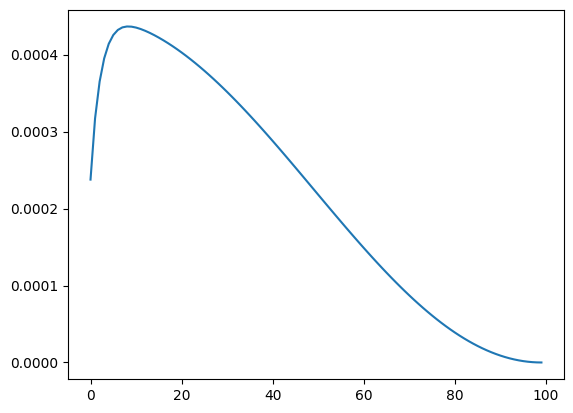

100%|██████████| 18/18 [00:00<00:00, 90.96it/s]


Test Loss: 0.471 | Accuracy: 76.718


In [21]:
all_targets = ['LMST' ]

for target in all_targets:
    print(f'Processing target: {target}')
    model = Net3( input_size=43)
    process_target(df, target, model)

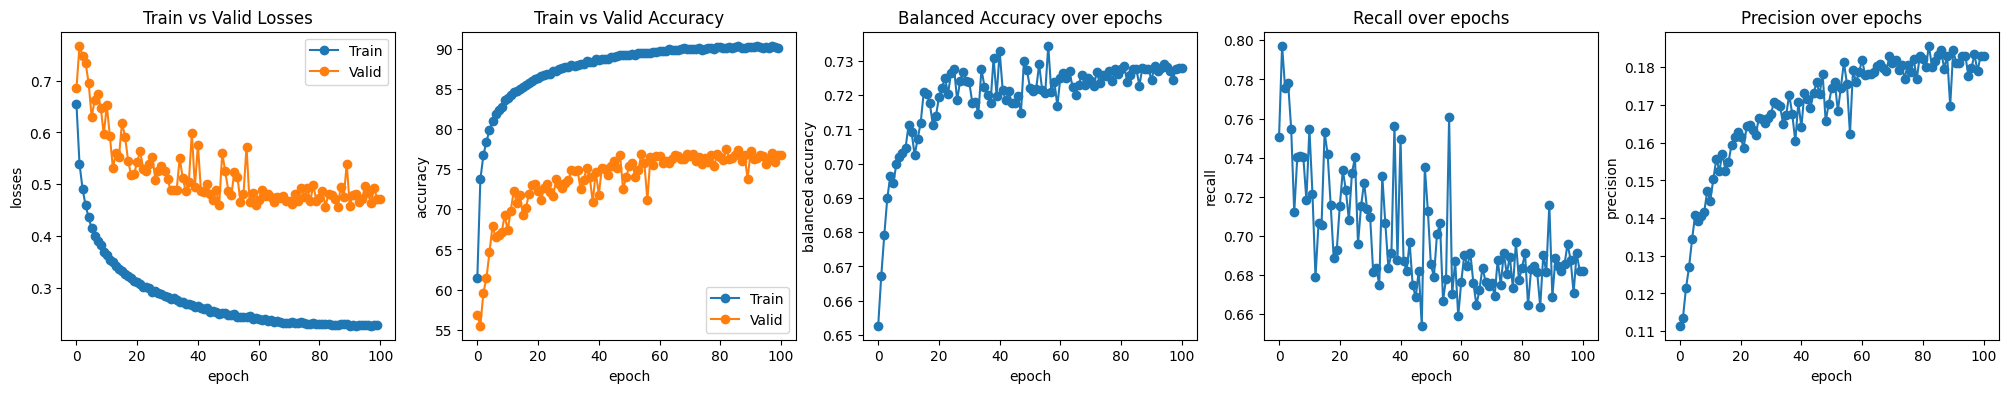

In [22]:
# plot the loss and accuracy and
metrics = {
    'train_losses': train_losses,
    'train_accu': train_accu,
    'eval_losses': eval_losses,
    'eval_accu': eval_accu,
    'balance_accuracy_list': balance_accuracy_list,
    'precision_list': precision_list,
    'recall_list': recall_list
}
plot_metrics(metrics, ['loss', 'accuracy', 'balance_accuracy', 'recall', 'precision'])